In [215]:
import numpy as np
import pandas as pd
from hear21passt.base import get_basic_model

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

import os
import glob

import torchaudio as ta

import torch

from tqdm.notebook import tqdm

In [216]:
QUERY_ROOT = "/home/kwatchar3/Documents/data/moisesdb/npyq"

In [217]:
query_files = glob.glob(os.path.join(QUERY_ROOT, "**", "*.query-10s.npy"), recursive=True)

In [218]:
passt = get_basic_model(mode="embed_only", arch="openmic").eval().cuda()

resample = ta.transforms.Resample(
            orig_freq=44100, new_freq=32000
        ).eval()



 Loading PASST TRAINED ON OpenMIC-2008 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,

In [219]:
PASST_ROOT = "/home/kwatchar3/Documents/data/moisesdb/passt"

for query_file in tqdm(query_files):
    query = np.load(query_file)
    query = resample(torch.from_numpy(query)).cuda()

    specs = passt.mel(query)[..., :998]
    specs = specs[:, None, ...]
    _, z = passt.net(specs)

    # print(z.shape)

    passt_path = query_file.replace(".query-10s.npy", ".passt.npy").replace(QUERY_ROOT, PASST_ROOT)

    # print(passt_path)

    os.makedirs(os.path.dirname(passt_path), exist_ok=True)

    np.save(passt_path, z.detach().cpu().numpy())


  0%|          | 0/4000 [00:00<?, ?it/s]

In [220]:
passts = glob.glob(os.path.join(PASST_ROOT, "**", "*.passt.npy"), recursive=True)

passt_data = []
stem_data = []

for passt_file in tqdm(passts):
    passt = np.load(passt_file)
    passt_data.append(passt)

    stem = passt_file.split("/")[-1].split(".")[0]

    stem_data.append(stem)

passt_data = np.stack(passt_data)


passt_data = passt_data.mean(axis=1)


  0%|          | 0/4000 [00:00<?, ?it/s]

In [221]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)

tsne_data = tsne.fit_transform(passt_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.003s...
[t-SNE] Computed neighbors for 4000 samples in 0.418s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 8.480191
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.466125
[t-SNE] KL divergence after 1000 iterations: 0.840812


In [222]:

FINE_LEVEL_INSTRUMENTS = {
    "lead_male_singer",
    "lead_female_singer",
    "human_choir",
    "background_vocals",
    "other_vocals",
    "bass_guitar",
    "bass_synthesizer",
    "contrabass_double_bass",
    "tuba",
    "bassoon",
    "snare_drum",
    "toms",
    "kick_drum",
    "cymbals",
    "overheads",
    "full_acoustic_drumkit",
    "drum_machine",
    "hihat",
    "fx",
    "click_track",
    "clean_electric_guitar",
    "distorted_electric_guitar",
    "lap_steel_guitar_or_slide_guitar",
    "acoustic_guitar",
    "other_plucked",
    "atonal_percussion",
    "pitched_percussion",
    "grand_piano",
    "electric_piano",
    "organ_electric_organ",
    "synth_pad",
    "synth_lead",
    "other_sounds",
    "violin",
    "viola",
    "cello",
    "violin_section",
    "viola_section",
    "cello_section",
    "string_section",
    "other_strings",
    "brass",
    "flutes",
    "reeds",
    "other_wind",
}

COARSE_LEVEL_INSTRUMENTS = {
    "vocals",
    "bass",
    "drums",
    "guitar",
    "other_plucked",
    "percussion",
    "piano",
    "other_keys",
    "bowed_strings",
    "wind",
    "other",
}

COARSE_TO_FINE = {
    "vocals": [
        "lead_male_singer",
        "lead_female_singer",
        "human_choir",
        "background_vocals",
        "other_vocals",
    ],
    "bass": [
        "bass_guitar",
        "bass_synthesizer",
        "contrabass_double_bass",
        "tuba",
        "bassoon",
    ],
    "drums": [
        "snare_drum",
        "toms",
        "kick_drum",
        "cymbals",
        "overheads",
        "full_acoustic_drumkit",
        "drum_machine",
        "hihat",
    ],
    "other": ["fx", "click_track"],
    "guitar": [
        "clean_electric_guitar",
        "distorted_electric_guitar",
        "lap_steel_guitar_or_slide_guitar",
        "acoustic_guitar",
    ],
    "other_plucked": ["other_plucked"],
    "percussion": ["atonal_percussion", "pitched_percussion"],
    "piano": ["grand_piano", "electric_piano"],
    "other_keys": ["organ_electric_organ", "synth_pad", "synth_lead", "other_sounds"],
    "bowed_strings": [
        "violin",
        "viola",
        "cello",
        "violin_section",
        "viola_section",
        "cello_section",
        "string_section",
        "other_strings",
    ],
    "wind": ["brass", "flutes", "reeds", "other_wind"],
}

COARSE_TO_FINE = {k: set(v) for k, v in COARSE_TO_FINE.items()}
FINE_TO_COARSE = {k: kk for kk, v in COARSE_TO_FINE.items() for k in v}

ALL_LEVEL_INSTRUMENTS = COARSE_LEVEL_INSTRUMENTS.union(FINE_LEVEL_INSTRUMENTS)

In [223]:
tsne_data = pd.concat([pd.DataFrame(tsne_data, columns=["x", "y"]), pd.Series(stem_data, name="stem")], axis=1)

In [224]:
tsne_data["coarse"] = tsne_data["stem"].apply(lambda x: FINE_TO_COARSE[x] if x in FINE_LEVEL_INSTRUMENTS else x)

<Axes: xlabel='x', ylabel='y'>

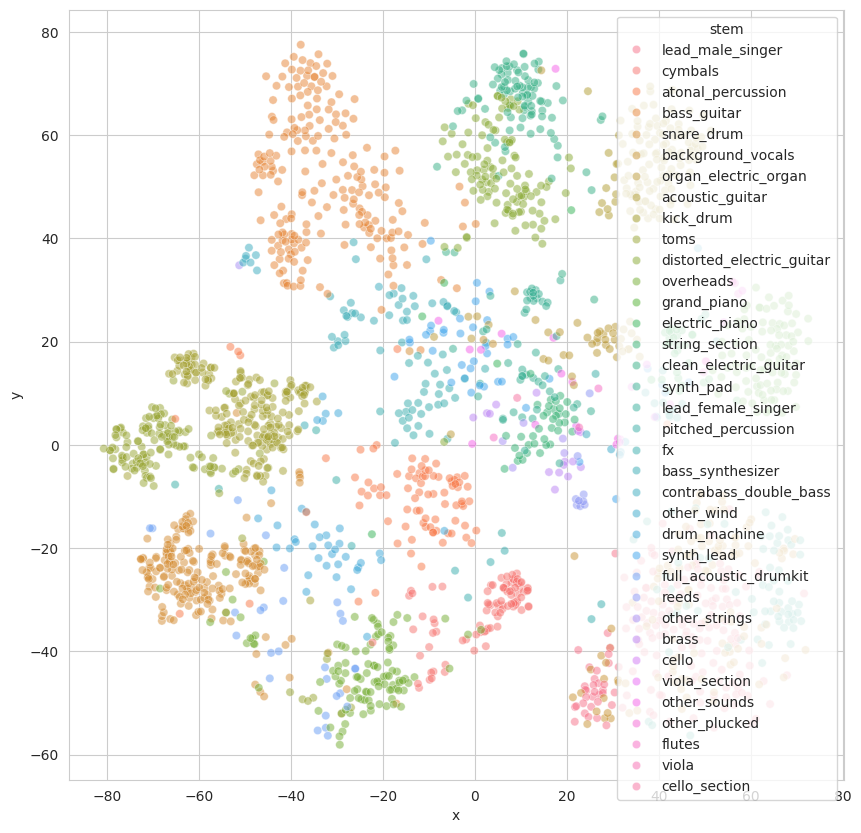

In [225]:
tsne_fine = tsne_data[tsne_data["stem"].isin(FINE_LEVEL_INSTRUMENTS)]

plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsne_fine, x="x", y="y", hue="stem", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

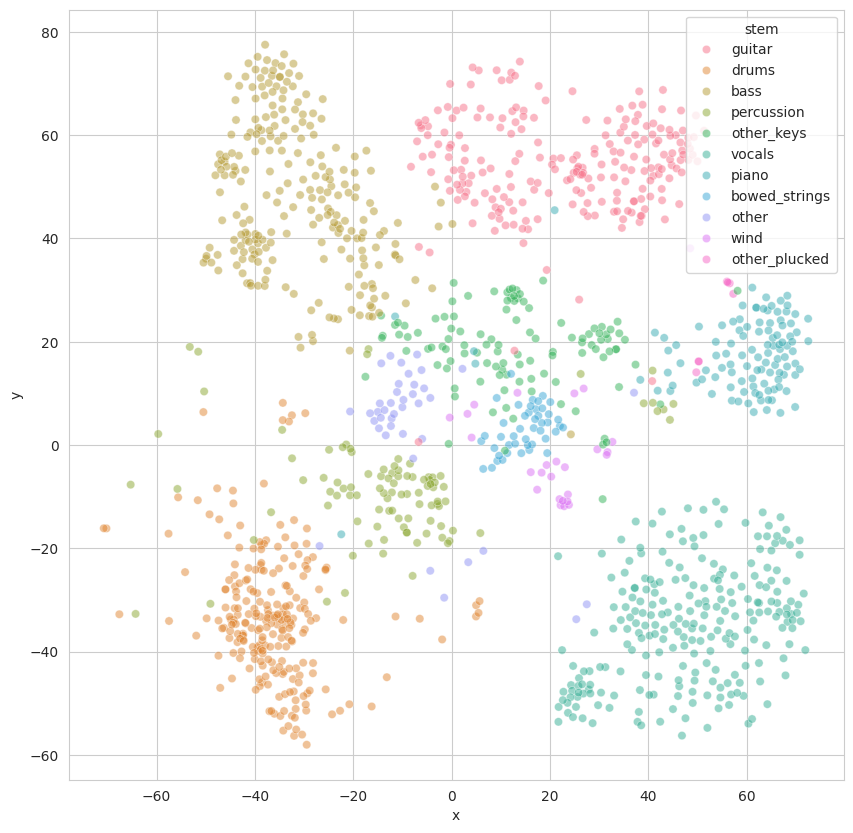

In [226]:
tsne_coarse = tsne_data[tsne_data["stem"].isin(COARSE_LEVEL_INSTRUMENTS)]

plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsne_coarse, x="x", y="y", hue="stem", alpha=0.5)

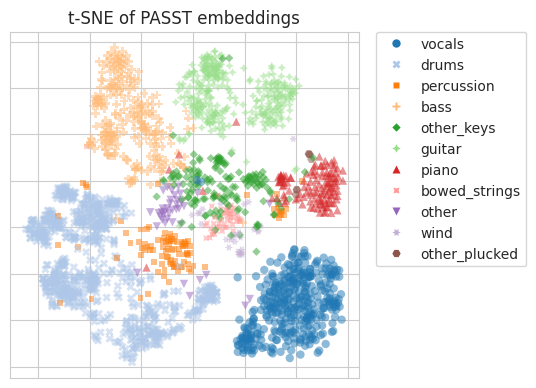

In [227]:
tsne_fine_coarse = tsne_data[tsne_data["stem"].isin(FINE_LEVEL_INSTRUMENTS)]

f, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
sns.scatterplot(data=tsne_fine_coarse,
                x="x", y="y",
                hue="coarse",
                edgecolor="none",
                alpha=0.5,
                style="coarse",
                palette="tab20",
                ax=ax
        )

ax.set(
    xlabel=None,
    ylabel=None,
    title="t-SNE of PASST embeddings",
    xticklabels=[],
    yticklabels=[]
)

leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for lh in leg.legend_handles:
    lh.set_alpha(1)

plt.show()

In [231]:
ALLOWED_INSTRUMENT = [
      "drums",
      "lead_male_singer",
      "lead_female_singer",
      # "human_choir",
      "background_vocals",
      # "other_vocals",
      "bass_guitar",
      "bass_synthesizer",
      # "contrabass_double_bass",
      # "tuba",
      # "bassoon",
      "fx",
      "clean_electric_guitar",
      "distorted_electric_guitar",
      # "lap_steel_guitar_or_slide_guitar",
      "acoustic_guitar",
      # "other_plucked",
      "pitched_percussion",
      "grand_piano",
      "electric_piano",
      "organ_electric_organ",
      "synth_pad",
      "synth_lead",
      # "violin",
      # "viola",
      # "cello",
      # "violin_section",
      # "viola_section",
      # "cello_section",
      "string_section",
      # "other_strings",
      "brass",
      # "flutes",
      "reeds",
      # "other_wind"
  ]

allowed_instruments_dtype = pd.CategoricalDtype(categories=ALLOWED_INSTRUMENT, ordered=True)

In [229]:
short_stem = {
    "drums": "Drums",
  "lead_male_singer": "Lead M. Vox",
  "lead_female_singer": "Lead F. Vox",
  # "human_choir",
  "background_vocals": "Bg. Vox",
  # "other_vocals",
  "bass_guitar": "Bass Gtr.",
  "bass_synthesizer": "Bass Synth",
  # "contrabass_double_bass",
  # "tuba",
  # "bassoon",
  "fx": "Fx",
  "clean_electric_guitar": "Clean. E. Gtr.",
  "distorted_electric_guitar": "Dist. E. Gtr.",
  # "lap_steel_guitar_or_slide_guitar",
  "acoustic_guitar": "A. Gtr",
  "other_plucked": "Other Plucked",
  "pitched_percussion": "Pitched Perc.",
  "grand_piano": "Grand Piano",
  "electric_piano": "E. Piano",
  "organ_electric_organ": "Organ",
  "synth_pad": "Synth Pad",
  "synth_lead": "Synth Lead",
  # "violin",
  # "viola",
  # "cello",
  # "violin_section",
  # "viola_section",
  # "cello_section",
  "string_section": "Str. Sect.",
  "other_strings": "Other Str.",
  "brass": "Brass",
  # "flutes",
  "reeds": "Reeds",
  "other_wind": "Other Wind"
}

/tmp/ipykernel_273679/348515333.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centroids = tsne_allowed.groupby("stem")[["x", "y"]].mean()
/tmp/ipykernel_273679/348515333.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centroids = tsne_allowed.groupby("stem")[["x", "y"]].mean()


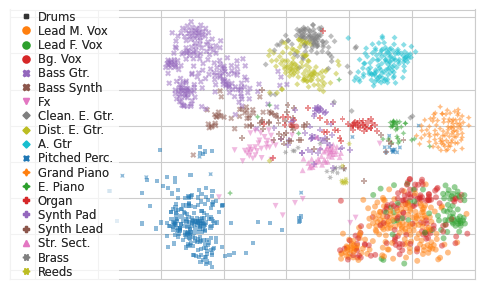

In [233]:
tsne_allowed = tsne_data[tsne_data["stem"].isin(ALLOWED_INSTRUMENT)].copy()

tsne_allowed["stem"] = tsne_allowed["stem"].astype(allowed_instruments_dtype)


f, ax = plt.subplots(1, 1, figsize=(6, 3.5))

sns.scatterplot(data=tsne_allowed,
                x="x", y="y",
                hue="stem",
                edgecolor="none",
                alpha=0.5,
                size=1,
                style="coarse",
                palette="tab10",
                ax=ax
        )

ax.set(
    xlabel=None,
    ylabel=None,
    xticklabels=[],
    yticklabels=[]
)

h, l = ax.get_legend_handles_labels()

stem_to_color = {ll: hh.get_markerfacecolor() for hh, ll in zip(h, l)}
coarse_to_marker = {ll: hh.get_marker() for hh, ll in zip(h, l)}


newh1 = []
newl1 = []

newh2 = []
newl2 = []

centroids = tsne_allowed.groupby("stem")[["x", "y"]].mean()

n_stems = len(ALLOWED_INSTRUMENT)

for stem in ALLOWED_INSTRUMENT:
    coarse_stem = FINE_TO_COARSE[stem] if stem in FINE_LEVEL_INSTRUMENTS else stem

    if True:
    #if centroids.loc[stem, "x"] < 0 or len(newh2) >= n_stems // 2:
        newh1.append(plt.Line2D([0], [0],
                                marker=coarse_to_marker[coarse_stem],
                                color=stem_to_color[stem],
                                markersize=5,
                                linestyle="None"))
        newl1.append(short_stem[stem])
    else:
        newh2.append(plt.Line2D([0], [0],
                                marker=coarse_to_marker[coarse_stem],
                                color=stem_to_color[stem],
                                markersize=5,
                                linestyle="None"))
        newl2.append(short_stem[stem])

ax.get_legend().remove()

l1 = plt.legend(newh1, newl1, loc="center left", borderaxespad=0., fontsize="small",
                frameon=True, handletextpad=0., columnspacing=0.8, labelspacing=0.1,
                framealpha=0.5, edgecolor="none")

ax.add_artist(l1)
# ax.add_artist(l2)

ax.set(xlim=[-110, 75])

centroids = tsne_allowed.groupby("stem")[["x", "y"]].mean()

plt.savefig("tsne.pdf", bbox_inches="tight")

plt.show()